In [1]:
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Lokta-Volterra system
$\begin{cases}
& \frac{dx}{dt} = \alpha x - \beta xy\\
& \frac{dy}{dt} = -\delta y + \gamma xy
\end{cases}$

Initial conditions: $x_0, y_0 = (0.44249296, 4.6280594)$

Parameters: $\alpha = 1.3 \\ \beta = 0.9\\ \gamma = 0.8\\ \delta =1.8$

In [2]:
alpha, beta, gamma, delta = 1.3, 0.9, 0.8, 1.8
x0, y0 = (0.44249296, 4.6280594)

In [3]:
class LotkaVolterraSystem:
    def __init__(self, alpha, beta, delta, gamma, X):
        self.alpha, self.beta, self.delta, self.gamma = alpha, beta, delta, gamma
        self.X = X
        
    def model(X, _, alpha, beta, delta, gamma):
        x, y = X
        dxdt = x * (alpha - beta * y)
        dydt = y * (-delta + gamma * x)
        return np.array([dxdt, dydt])
    
    def solve(self, t):
        res = odeint(LotkaVolterraSystem.model, self.X, t, args = (self.alpha, self.beta, self.delta, self.gamma))
        return res

In [4]:
LV = LotkaVolterraSystem(alpha=alpha, beta=beta, delta=delta, gamma=gamma, X=[x0,y0])

In [43]:
# Test
test_interval = [0,15]
number_of_samples = 10**3
t_test = torch.linspace(test_interval[0], test_interval[1], number_of_samples)

sol_test = LV.solve(t=t_test.numpy())
x_test, y_test = sol_test.T

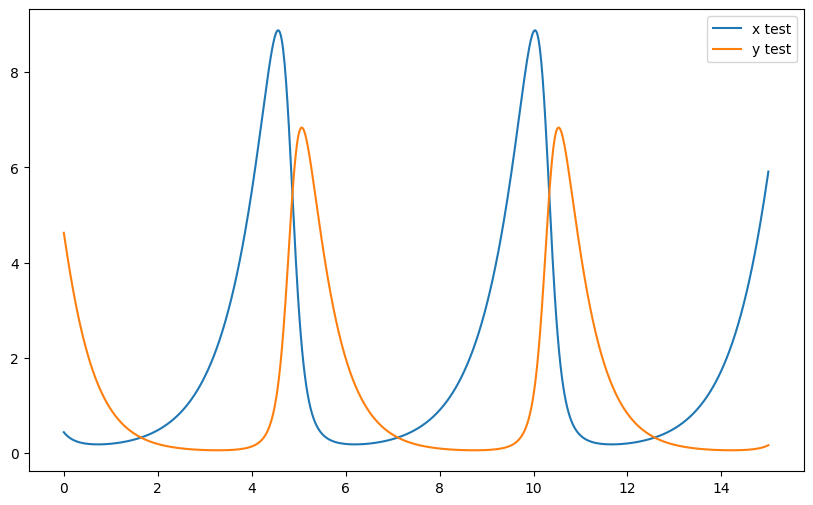

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_test, label="x test")
plt.plot(t_test, y_test, label="y test")
plt.legend()

In [45]:
train_interval = [0,15]
number_of_samples = int(7)

$$
(x_i)_{noise} =x_i +\epsilon \cdot \bar{x} \cdot N(0,1)
$$
$$
(y_i)_{noise} =y_i +\epsilon \cdot \bar{y} \cdot N(0,1)
$$

where $\bar{x}$ denotes the element-wise mean of $x_i$ over all $i$ and similarly for $\bar{y}$.

In [46]:
def get_noisy_measurements(t, lv):
    eps = 5e-2
    x_i, y_i = lv.solve(t=t).T
    mean_x, mean_y = np.mean(x_i), np.mean(y_i)
    x_noise, y_noise = np.random.normal(loc=0.0, scale=1.0, size=len(x_i)), np.random.normal(loc=0.0, scale=1.0, size=len(y_i))

    x_i = x_i + eps * mean_x * x_noise
    y_i = y_i + eps * mean_y * y_noise

    t = t.reshape((-1, 1))
    out = np.vstack((x_i, y_i)).T
    return out, t

In [47]:
sample_points = np.linspace(train_interval[0], train_interval[1], number_of_samples)
# np.concatenate((
#     np.linspace(train_interval[0], train_interval[1], number_of_samples) ,
#     np.linspace(12, 14, 30) ,
# ))
xy_train, t_train = get_noisy_measurements(sample_points, LV)

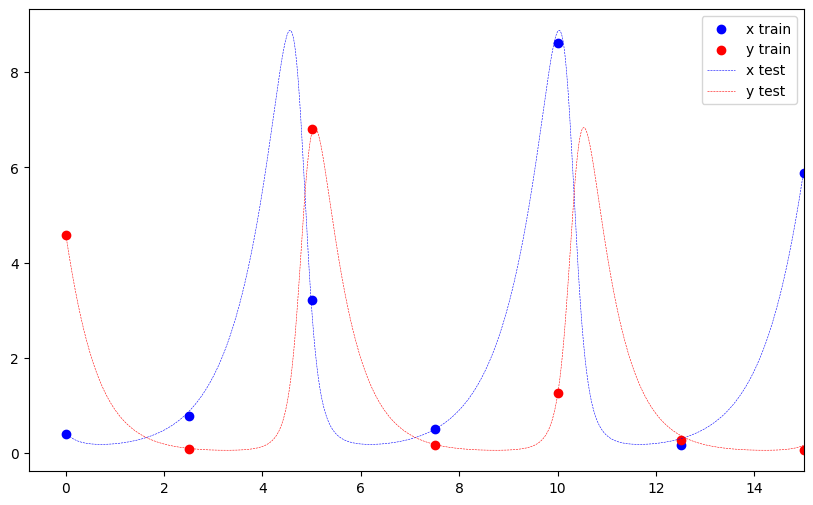

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(sample_points, xy_train[:,0], c="b", label="x train")
plt.scatter(sample_points, xy_train[:,1], c="r", label="y train")
plt.plot(t_test, x_test, c="b", label="x test", linestyle="--", linewidth=0.4)
plt.plot(t_test, y_test, c="r", label="y test", linestyle="--", linewidth=0.4)
plt.xlim(right=15)
plt.legend()

In [51]:
"""
Lotka-Volterra and Apoptosis model: 
    one input for t followed by a scaling layer; 2 
    hidden layers of 64 units for the surrogate 
    solution; 2 hidden layers of 16 units for the hidden 
    component approximation; sigmoid activation
"""

# class ScalingLayer(nn.Module):
#     def __init__(self, scale_init_value=1e-2, bias_init_value=0):
#         super().__init__()
#         self.scale = nn.Parameter(torch.FloatTensor([scale_init_value]))
#         self.bias = nn.Parameter(torch.FloatTensor([bias_init_value]))

#     def forward(self, input):
#         return input * self.scale + self.bias
    
    
class PINN(nn.Module):
    def __init__(self):
        super().__init__()

        self.scale = nn.Parameter(torch.FloatTensor([1e-2]))
        self.bias = nn.Parameter(torch.FloatTensor([0]))
        
        self.linear = nn.Sequential(
            nn.Linear(1, 64),
            nn.Sigmoid(),
            nn.Linear(64, 64),
            nn.Sigmoid(),
            nn.Linear(64, 16),
            nn.Sigmoid(),
            nn.Linear(16, 16),
            nn.Sigmoid(),
            nn.Linear(16, 2)
        )
        
    def forward(self, x):
        x = self.scale * x + self.bias 
        x = self.linear(x)
        return x

/var/folders/fg/77bc37kj4r73kcfvlxpjqfdc0000gn/T/ipykernel_31847/957837038.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_t_tensor = torch.tensor(t_test.reshape(-1, 1), requires_grad=True, dtype=torch.float32)


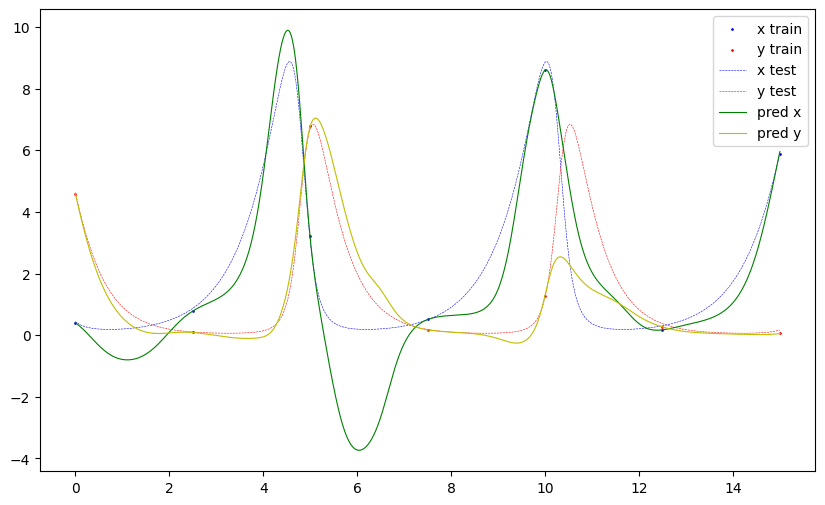

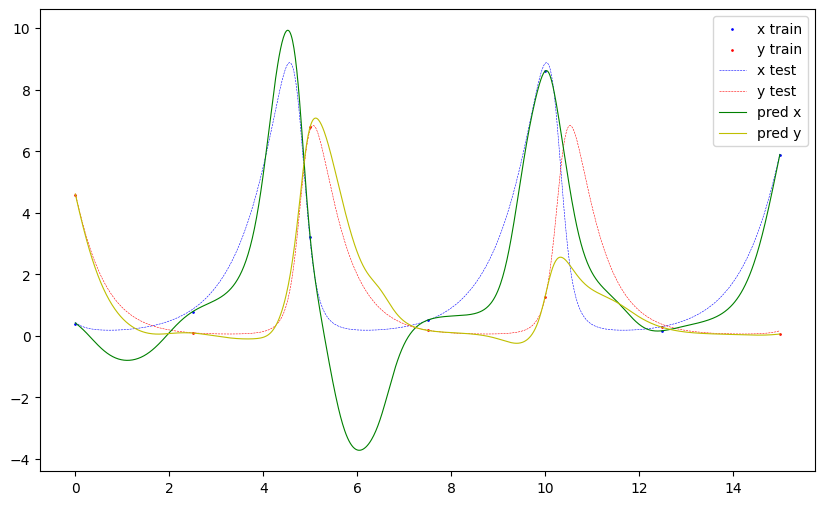

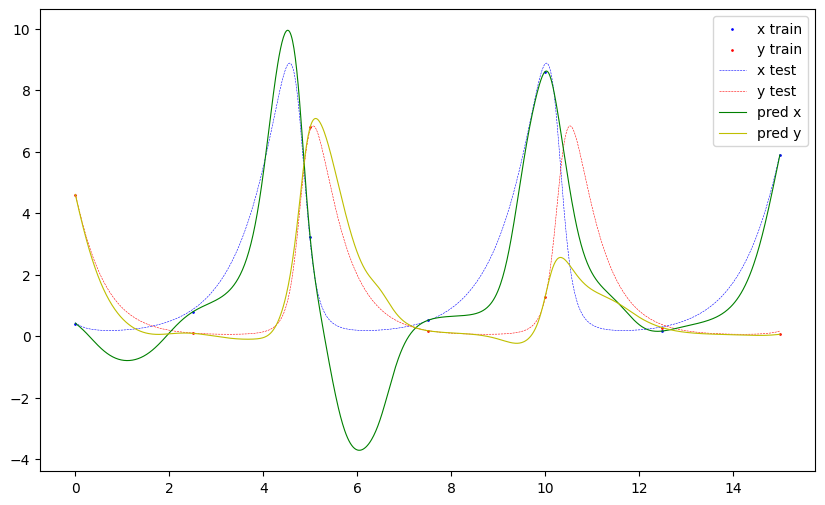

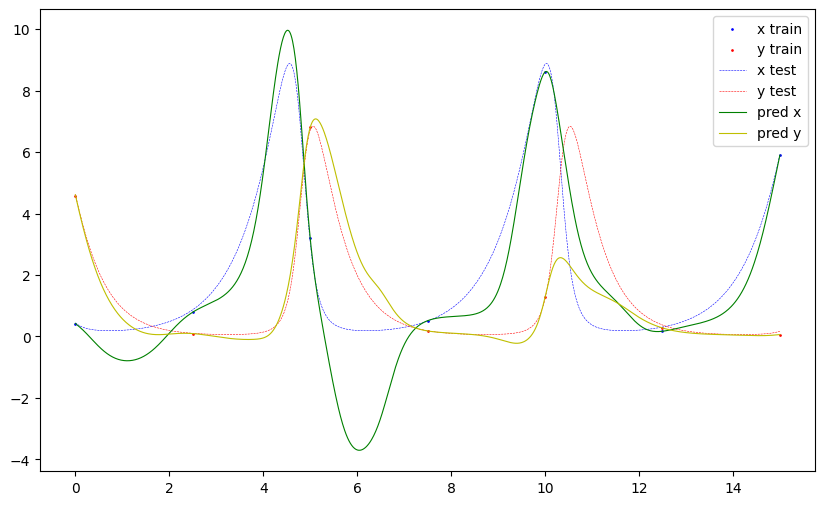

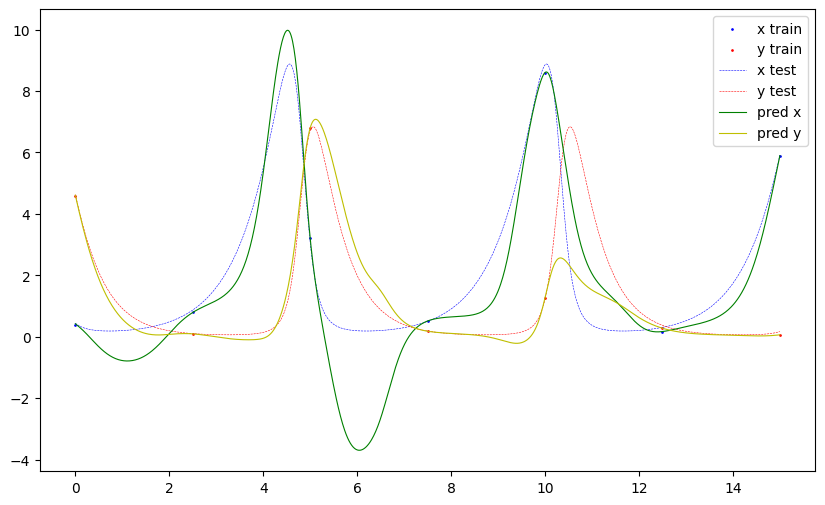

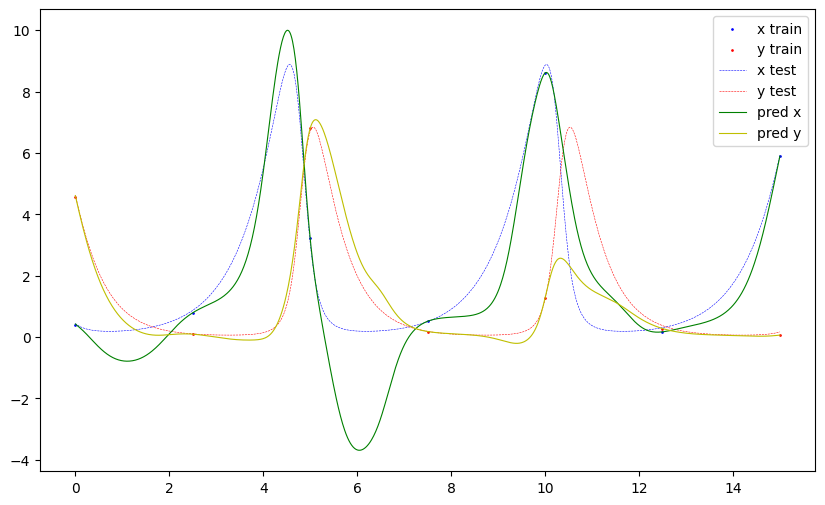

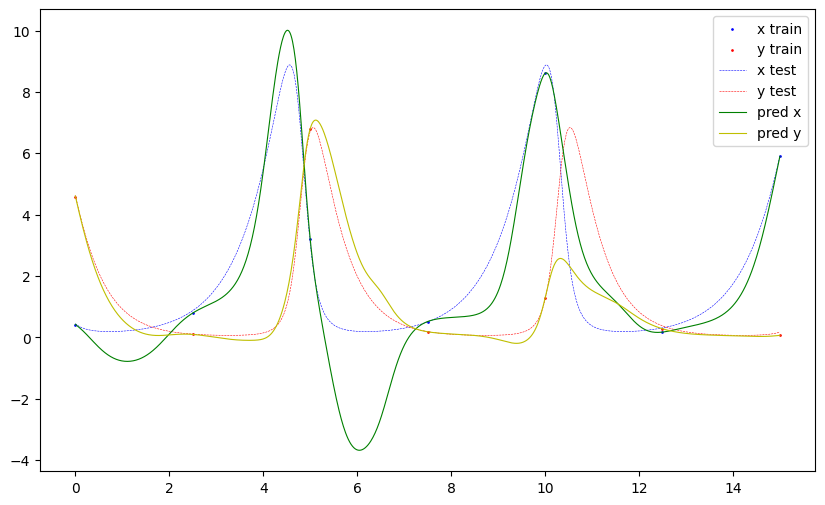

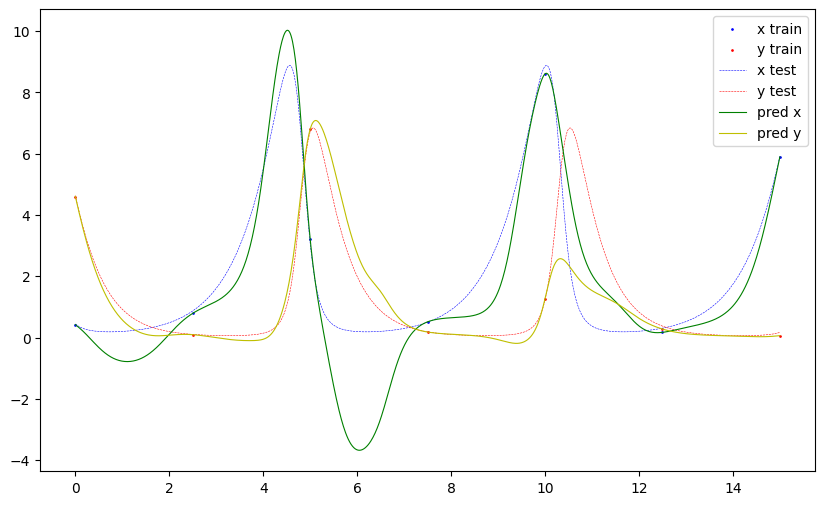

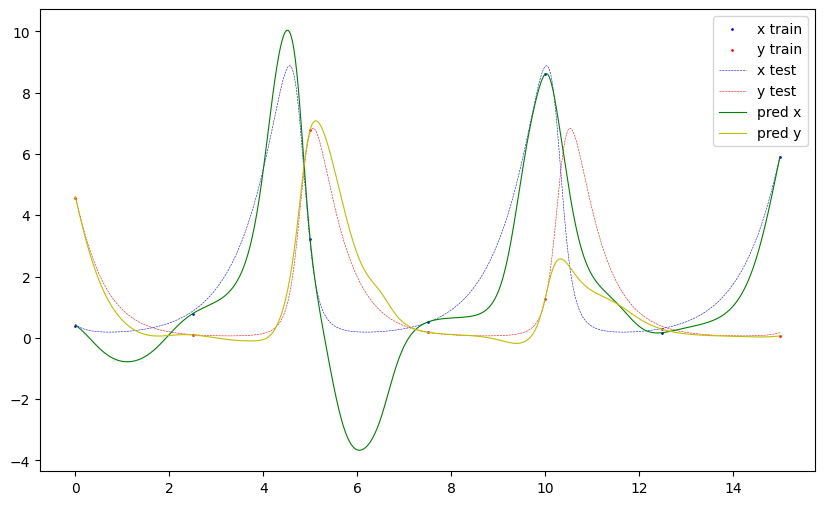

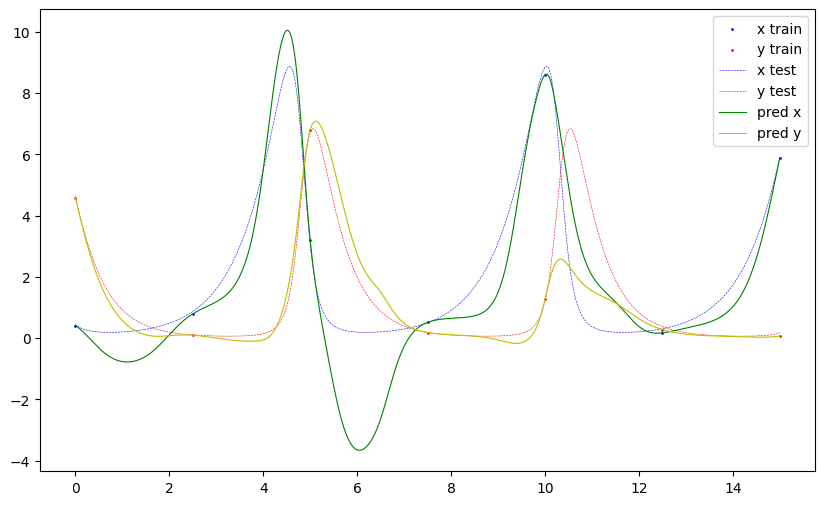

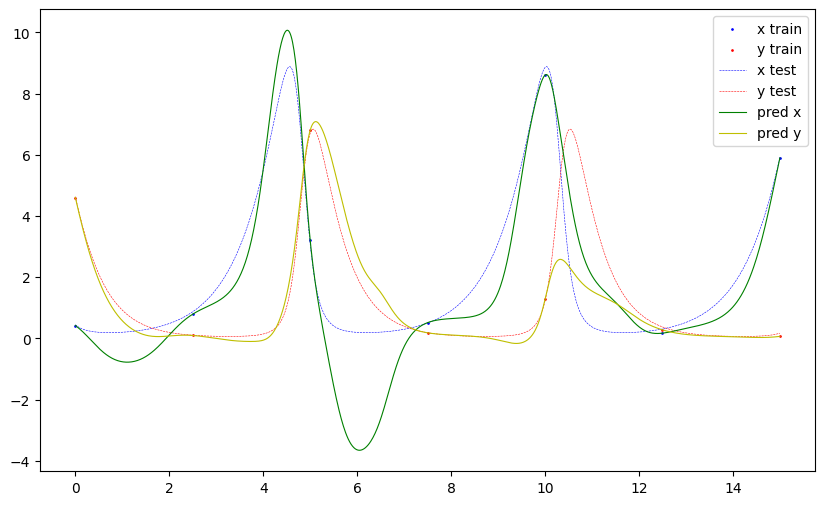

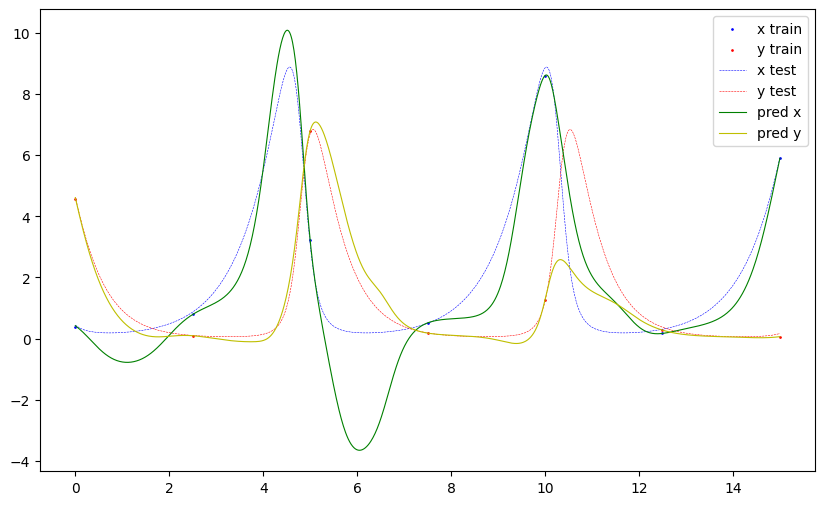

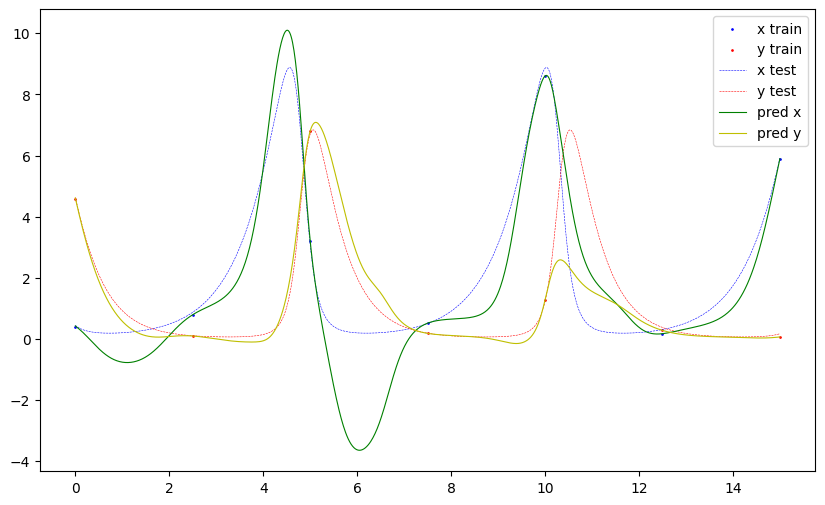

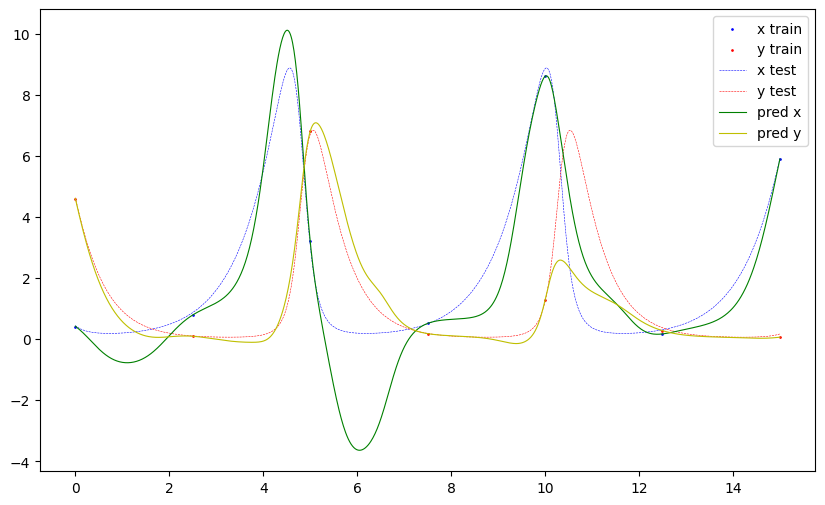

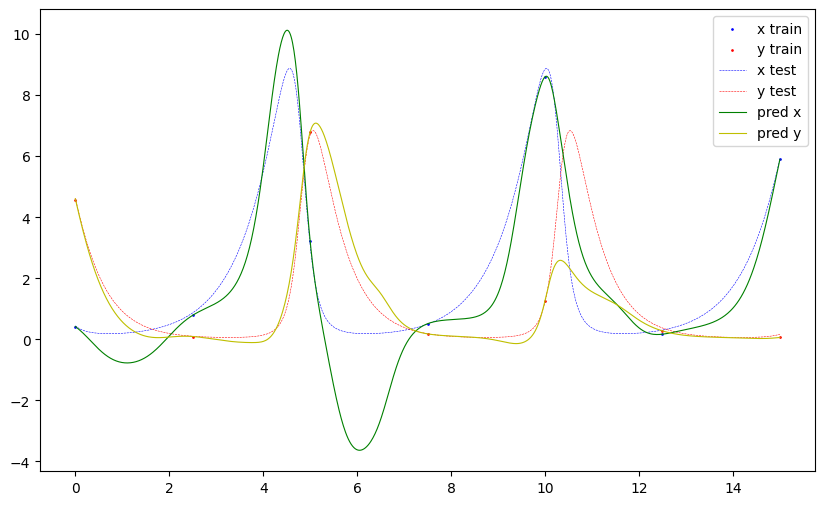

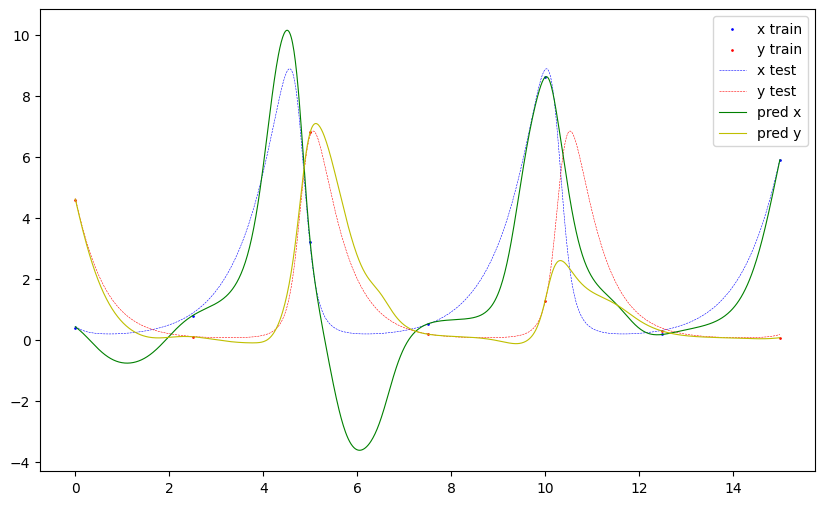

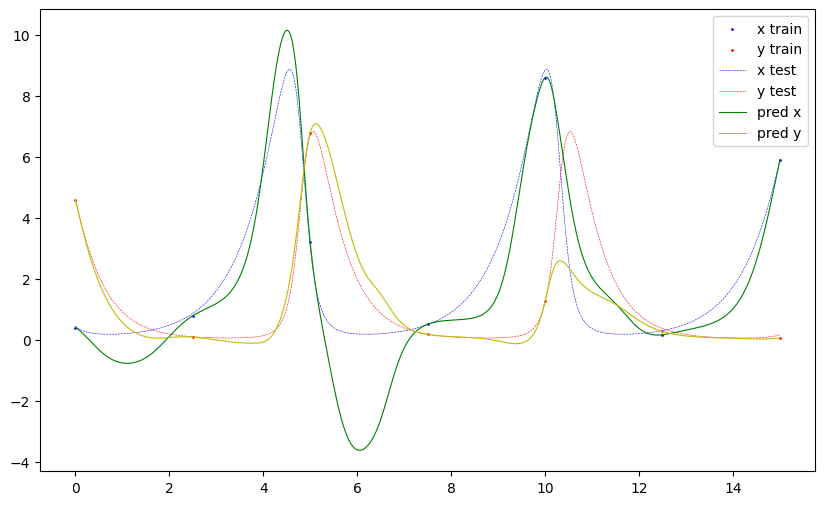

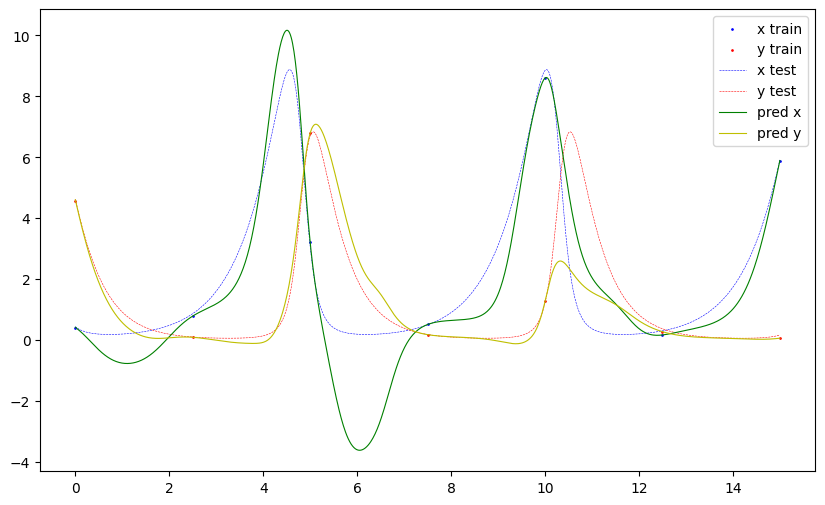

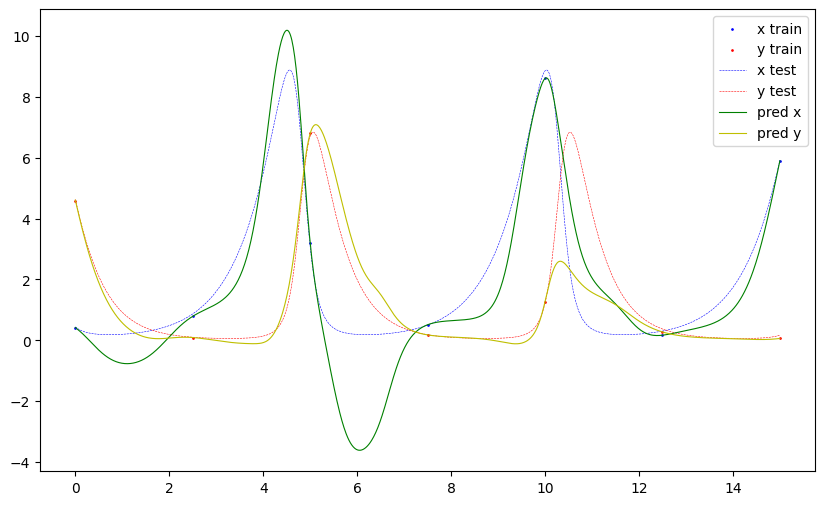

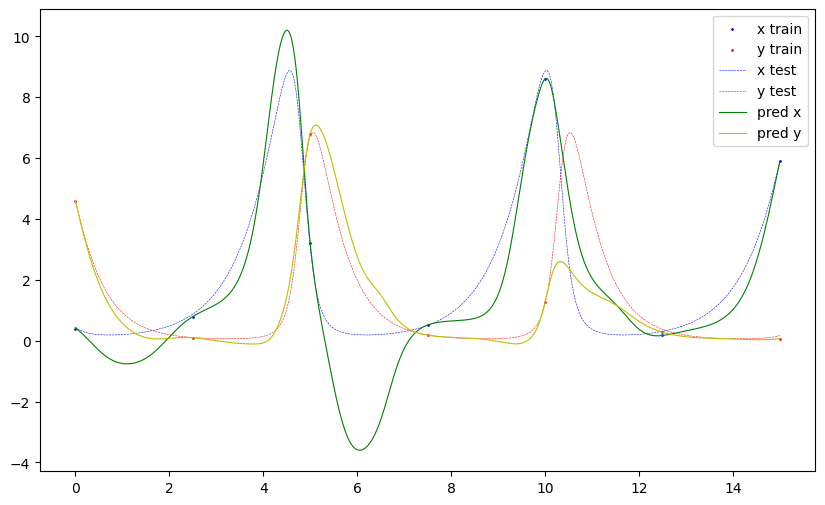

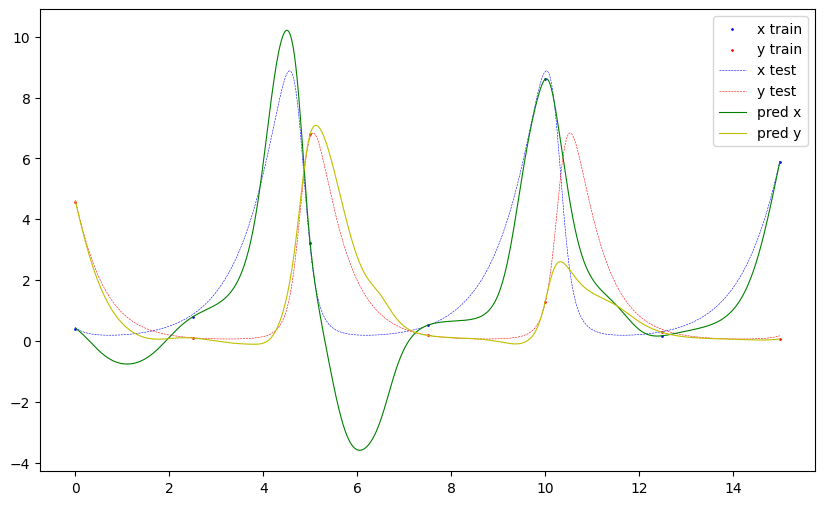

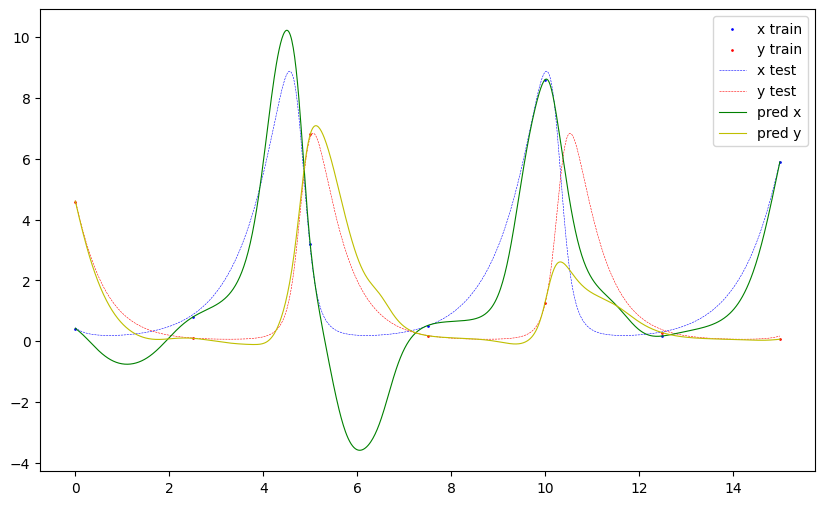

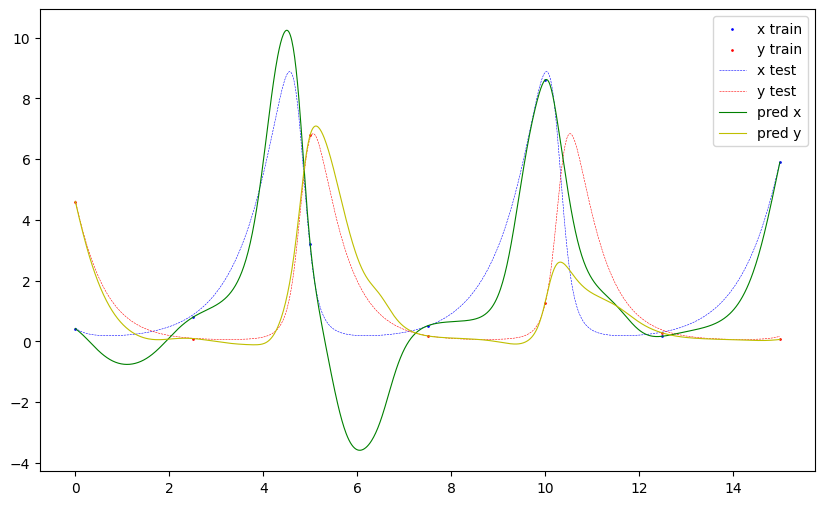

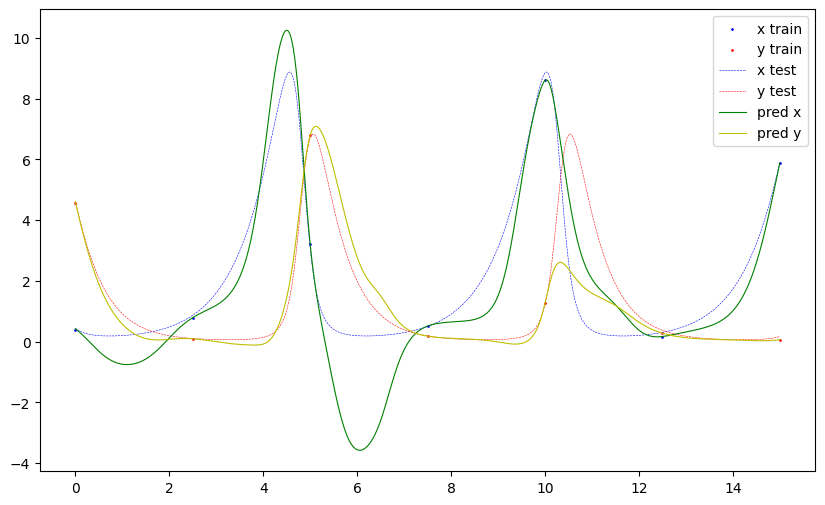

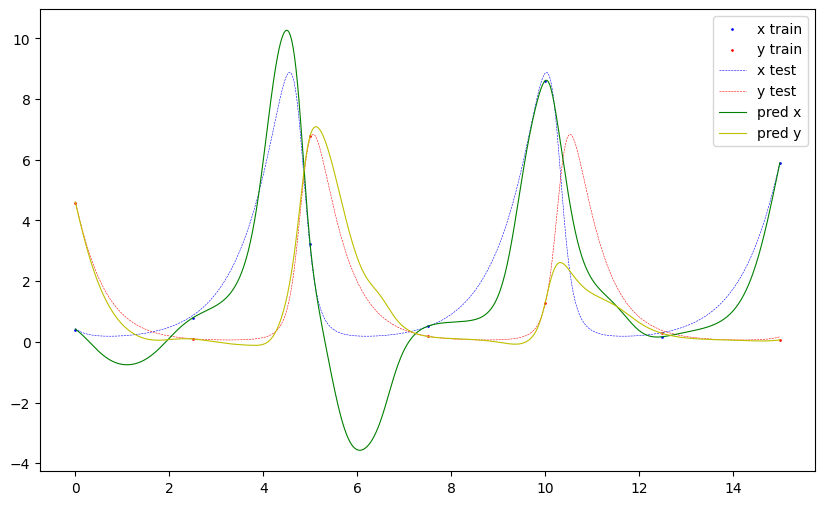

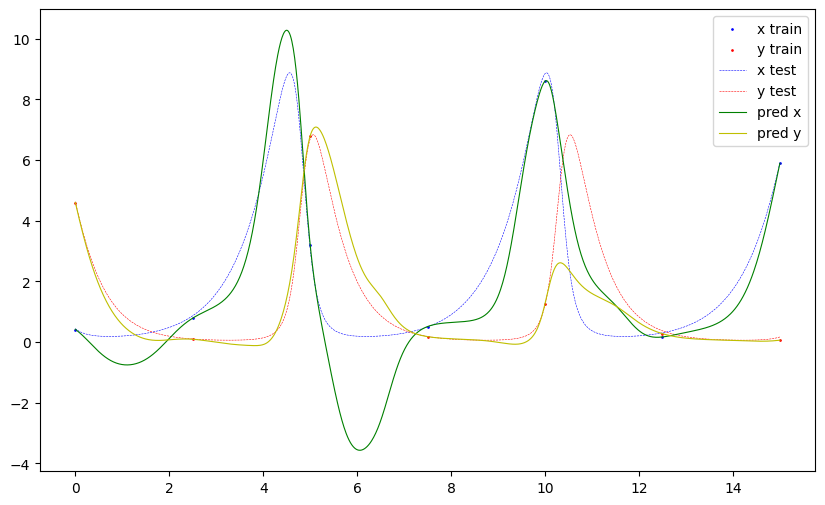

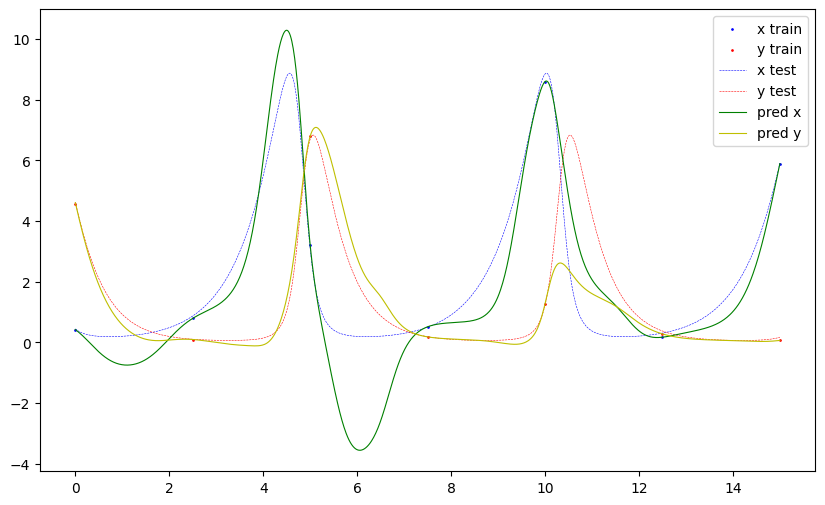

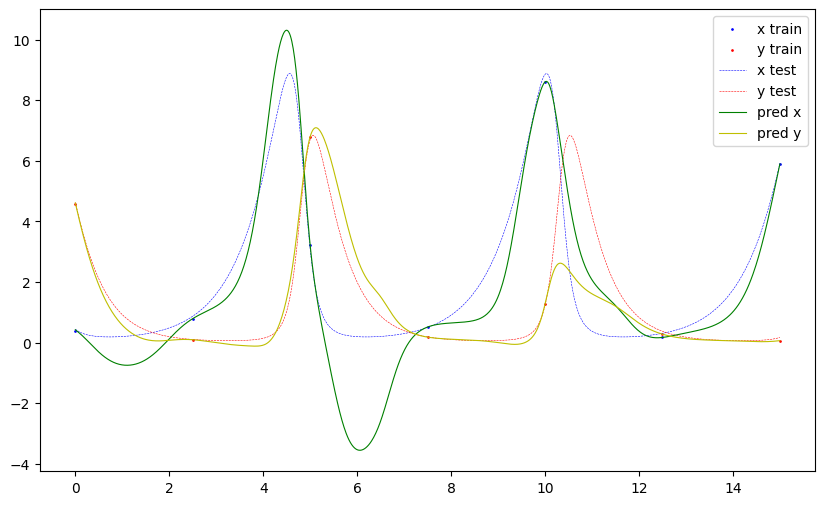

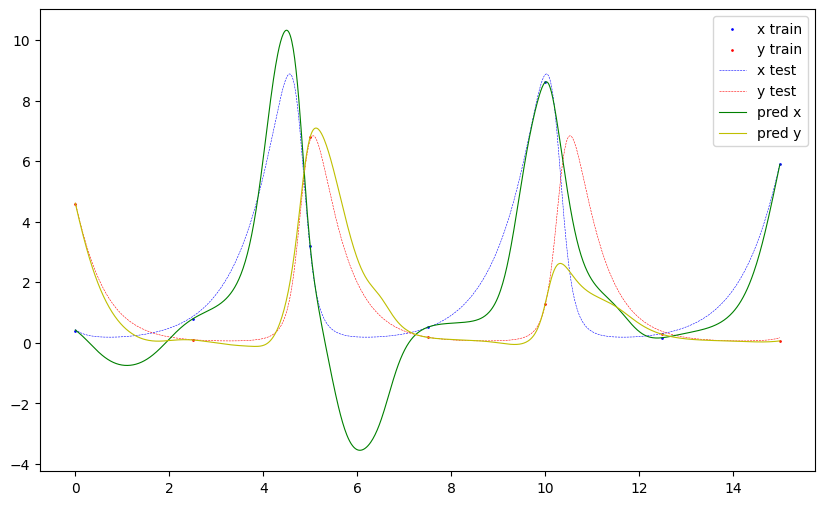

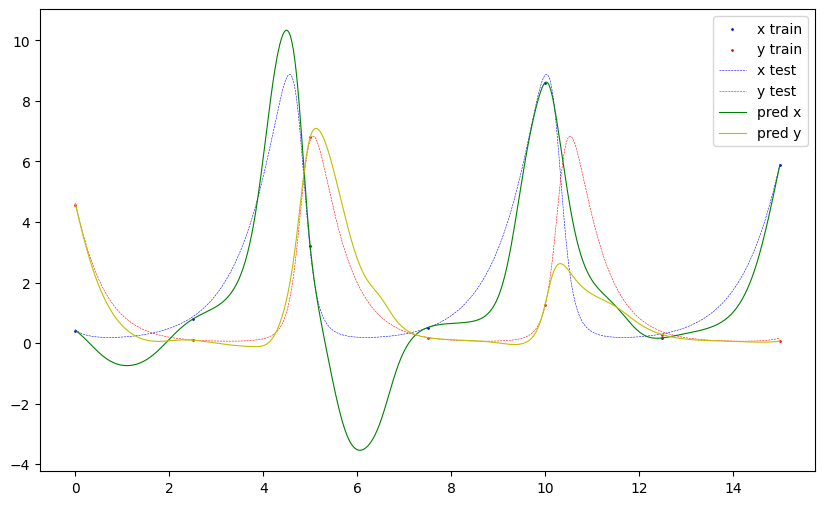

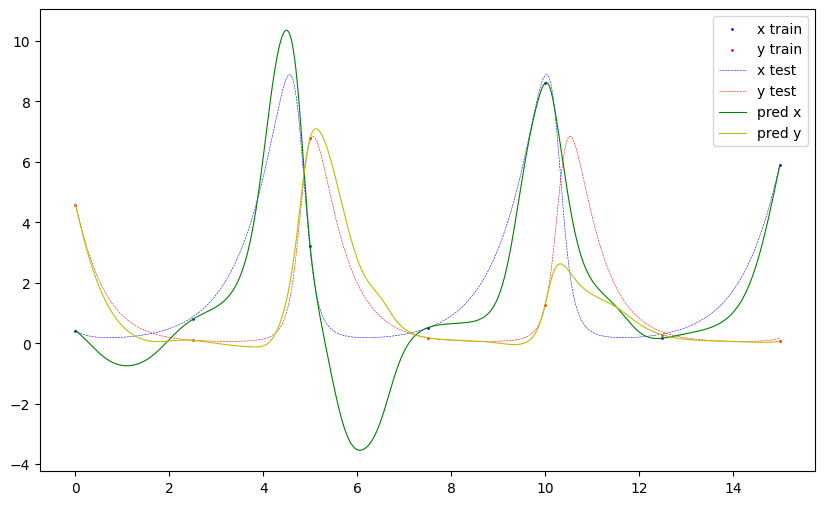

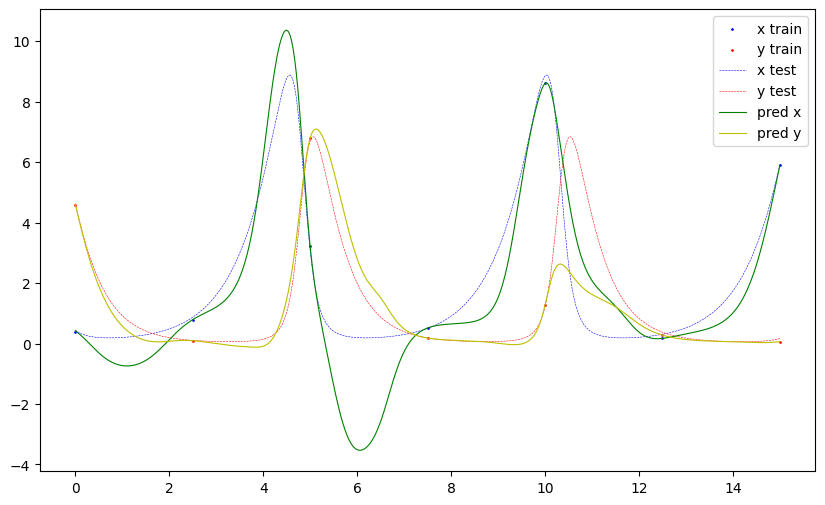

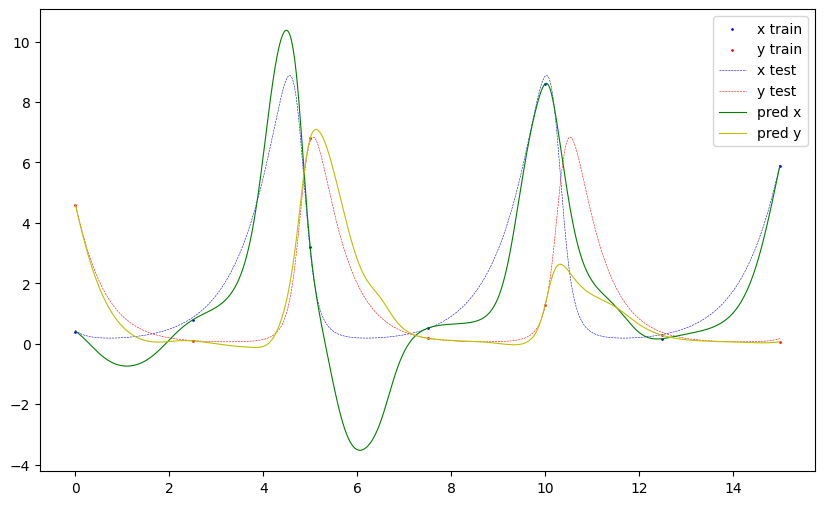

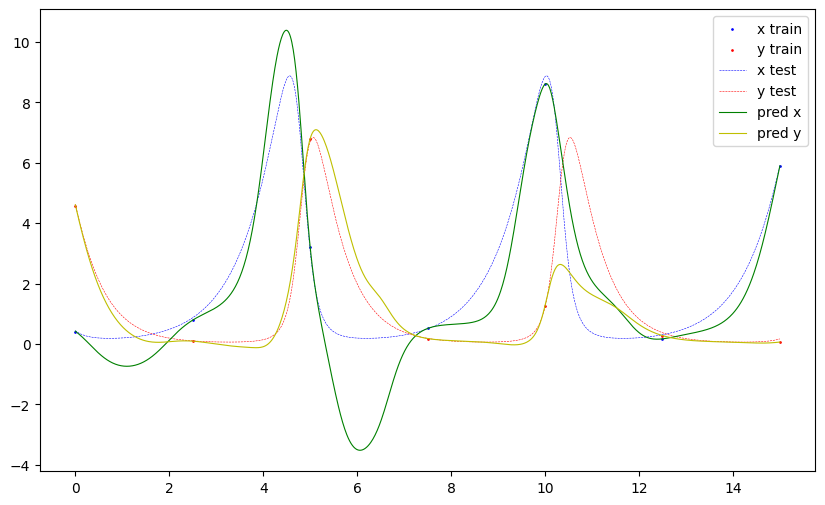

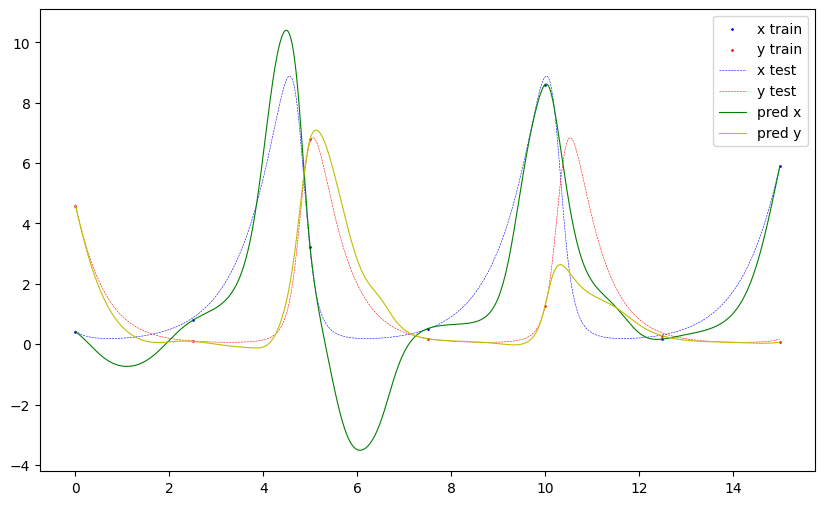

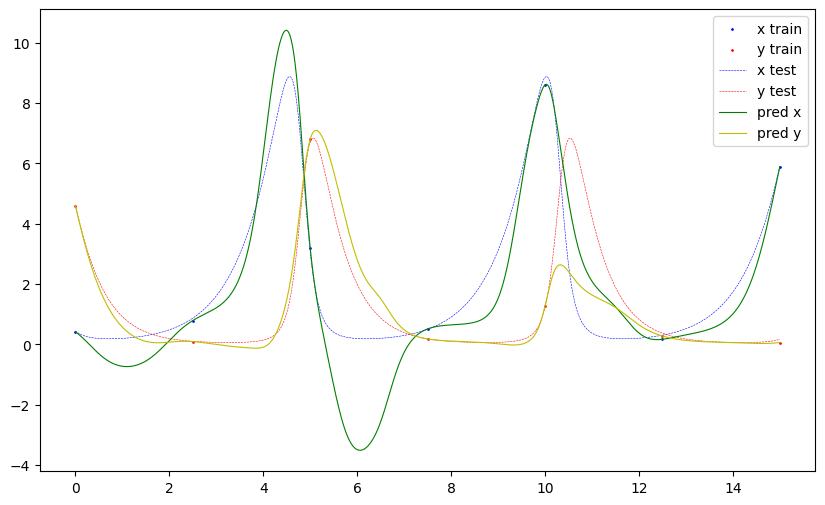

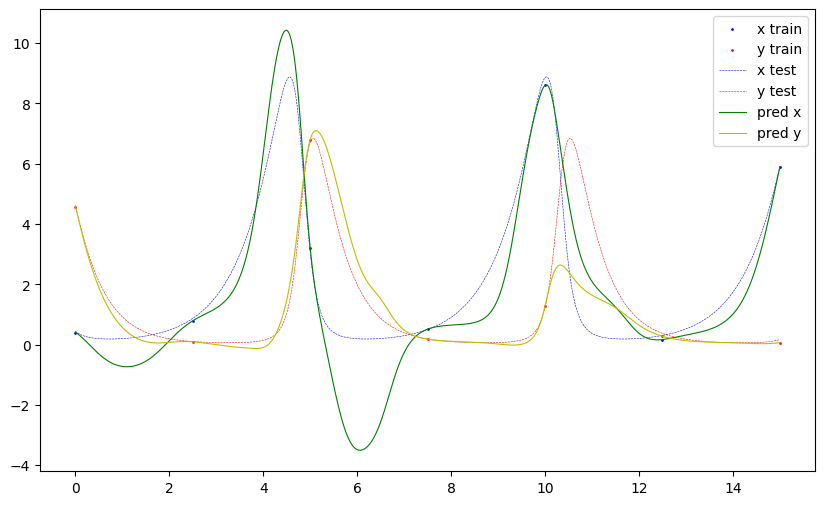

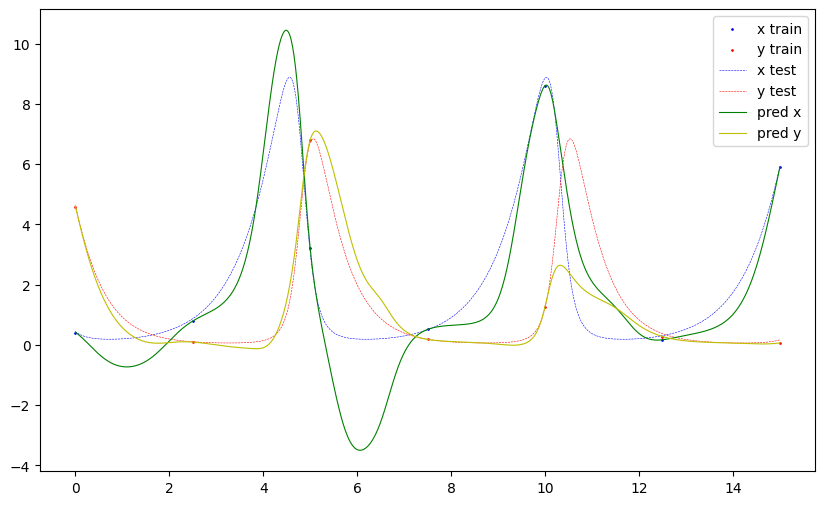

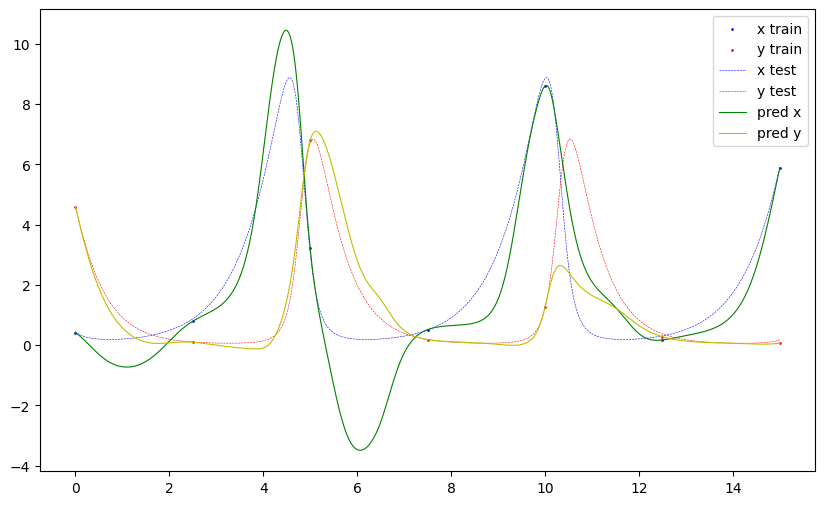

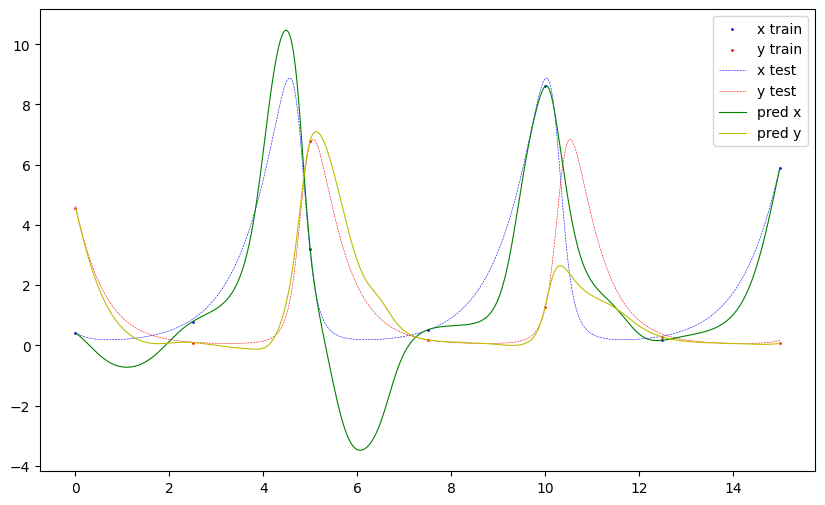

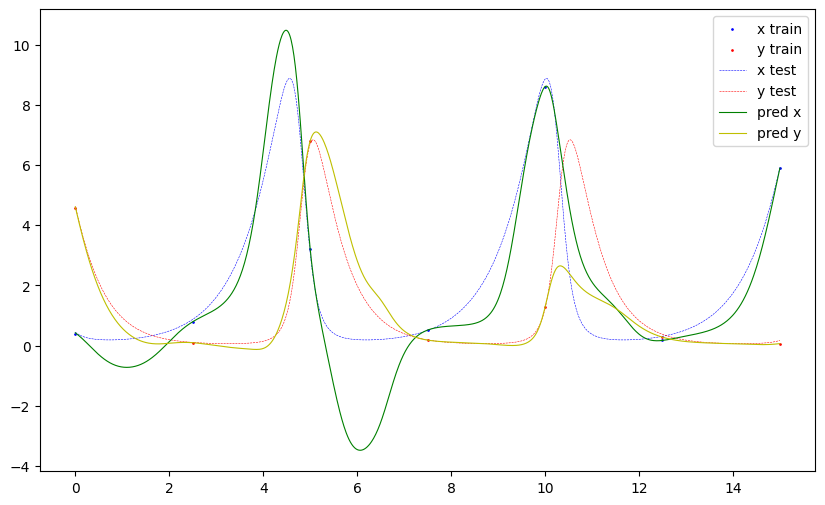

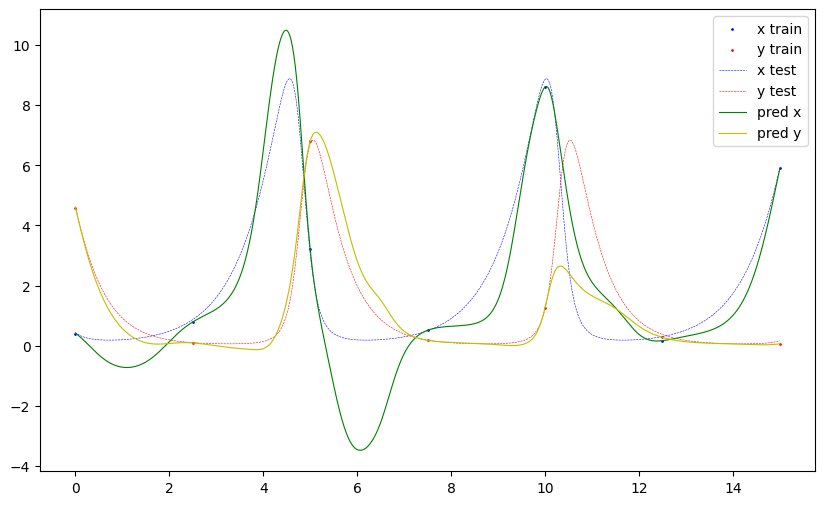

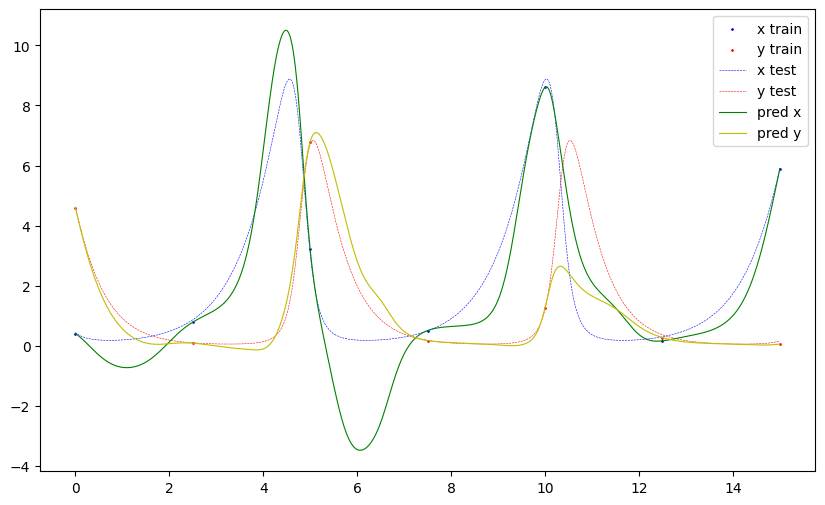

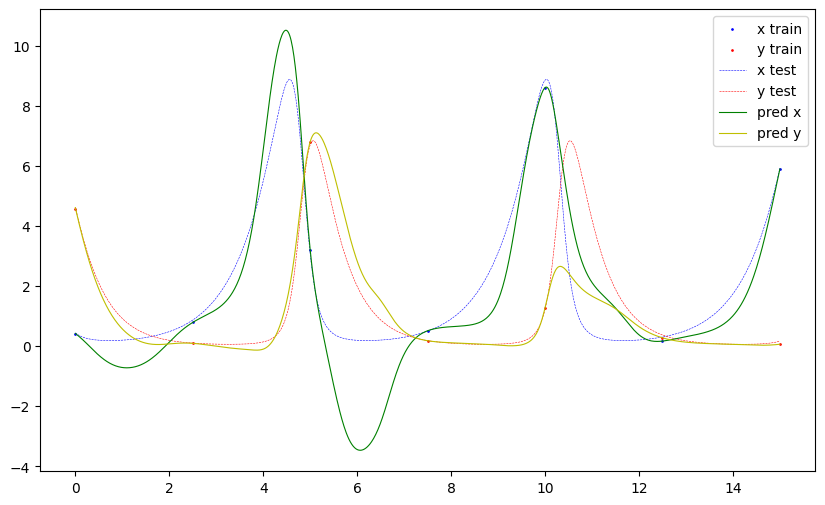

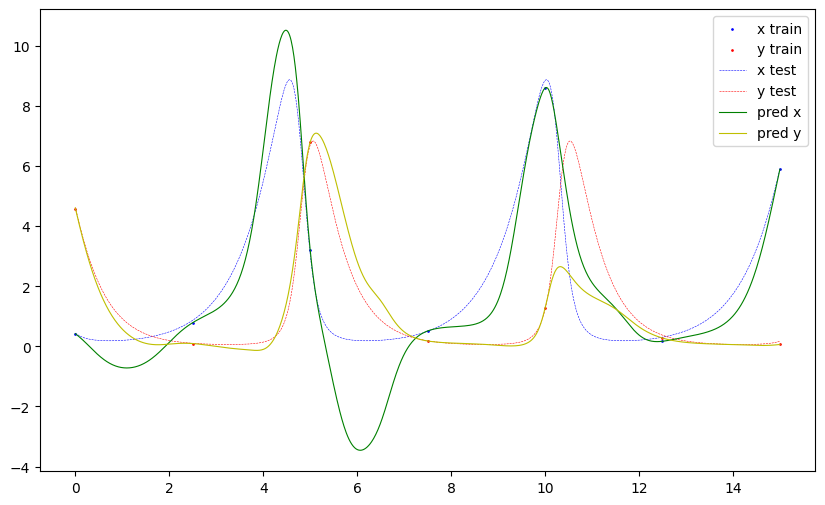

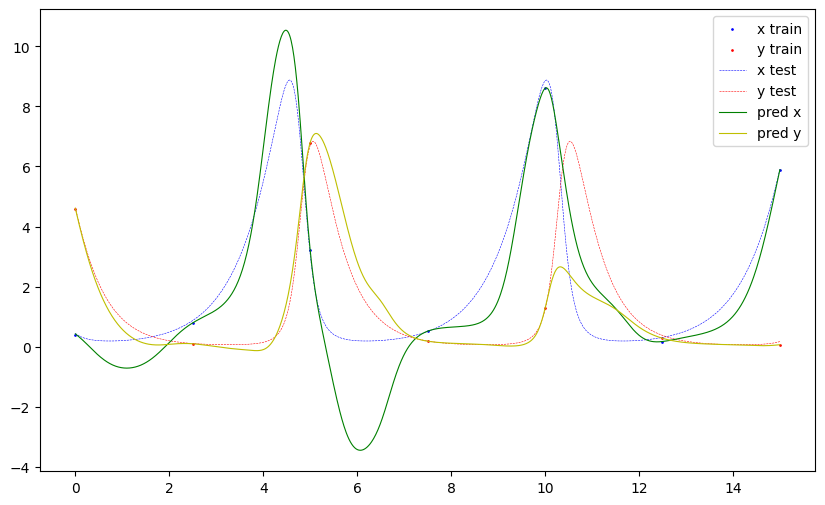

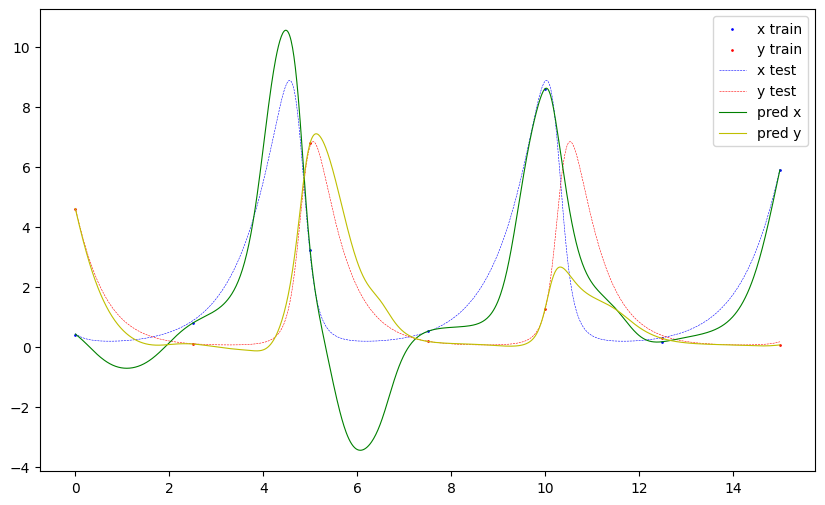

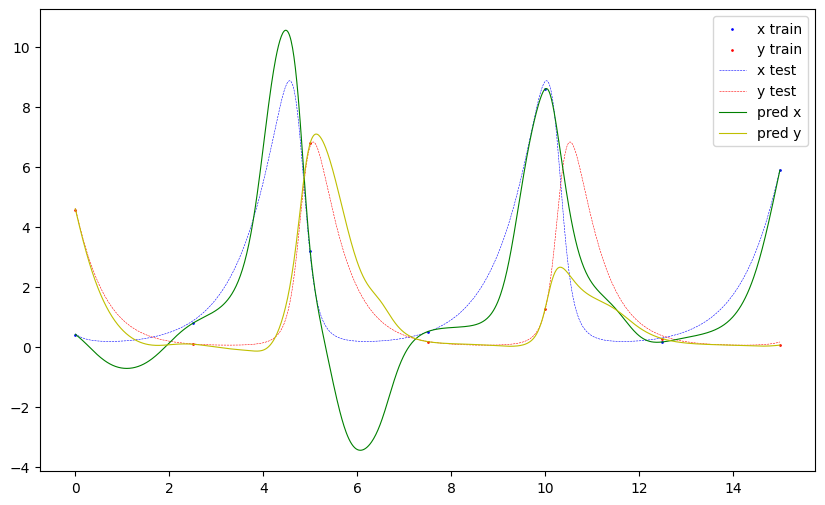

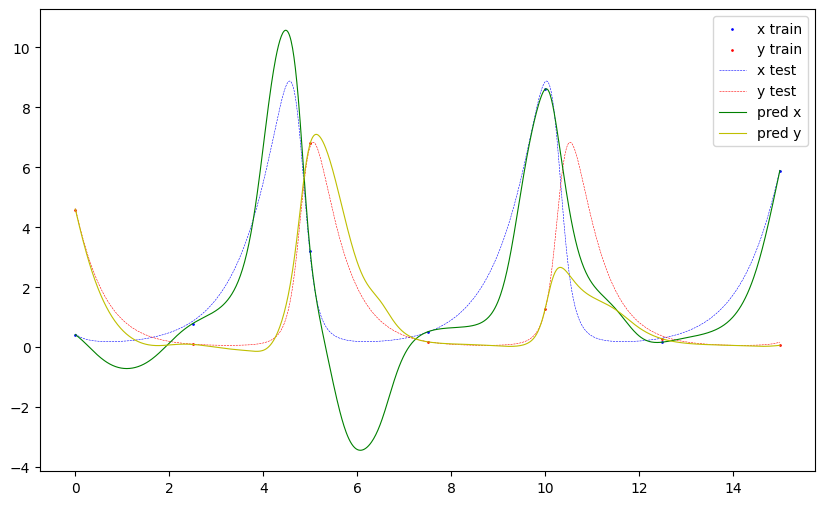

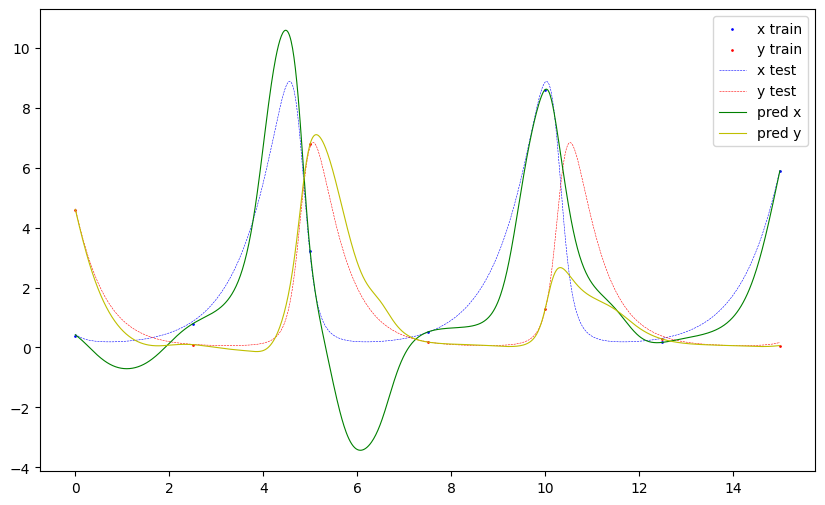

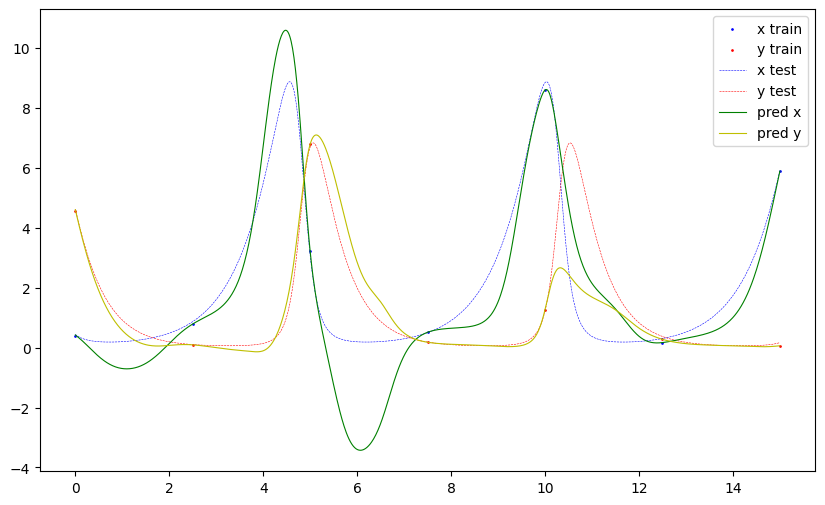

In [53]:
# pinn = PINN()

# Train
lr = 1e-4
optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
lambda1, lambda2, lambda3 = 1e0, 2e2, 5e0

train_data_tensor = torch.tensor(xy_train, requires_grad=True, dtype=torch.float32)
train_t_tensor = torch.tensor(t_train, requires_grad=True, dtype=torch.float32)

test_t_tensor = torch.tensor(t_test.reshape(-1, 1), requires_grad=True, dtype=torch.float32)


for i in range(1000001):
    optimizer.zero_grad()
    
    # boundary loss
    u_b = pinn(torch.tensor([0.], dtype=torch.float32))
    loss1 = nn.MSELoss()(u_b, torch.tensor([[x0, y0]], dtype=torch.float32)) # ensure the initial conditions

    # Physics loss
    u_p = pinn(train_t_tensor)
    dxdt = torch.autograd.grad(u_p[:, 0], train_t_tensor, torch.ones_like(train_t_tensor.reshape(-1)), create_graph=True)[0].reshape(-1)
    dydt = torch.autograd.grad(u_p[:, 1], train_t_tensor, torch.ones_like(train_t_tensor.reshape(-1)), create_graph=True)[0].reshape(-1)
    loss2 = nn.MSELoss()(
        torch.vstack((dxdt - LV.alpha * u_p[:, 0].reshape(-1) + LV.beta * u_p[:, 0].reshape(-1) * u_p[:, 1].reshape(-1),
        dydt + LV.delta * u_p[:, 1].reshape(-1) - LV.gamma * u_p[:, 0].reshape(-1) * u_p[:, 1].reshape(-1))).T,
        torch.zeros_like(u_p)
    )
    
    # Datapoint loss
    u_n = pinn(train_t_tensor) 
    #     loss3 = torch.mean((u_n - measurements.T)**2) # equivalent
    loss3 = nn.MSELoss()(u_n, train_data_tensor)
    
    
#     print(loss1.item(), loss2.item(), loss3.item())
    loss = lambda1*loss1 + lambda2*loss2  + lambda3*loss3 ## Why does it break?
    
    loss.backward()
    optimizer.step()
    
    if i% 20000 == 0:
        with torch.no_grad():
            pred = pinn(test_t_tensor) 
            plt.figure(figsize=(10, 6))
            plt.scatter(sample_points, xy_train[:,0], c="b", label="x train", s=0.9)
            plt.scatter(sample_points, xy_train[:,1], c="r", label="y train", s=0.9)
            plt.plot(t_test, x_test, c="b", label="x test", linestyle="--", linewidth=0.4)
            plt.plot(t_test, y_test, c="r", label="y test", linestyle="--", linewidth=0.4)
            plt.plot(t_test, pred.numpy()[:, 0], c='g', linewidth=0.8, label="pred x")
            plt.plot(t_test, pred.numpy()[:, 1], c='y', linewidth=0.8, label="pred y")
            plt.legend()
            plt.show()